# 02_comparacion_resultados — Análisis Completo de Baselines

**Objetivo:** Consolidar y comparar resultados de TODOS los baselines usando **Cross-Validation 5-fold** para estimaciones robustas.

**Estructura:**
1. Cargar resultados de CV de todos los modelos
2. Comparación estadística (medias, IC95%, overlaps)
3. Visualizaciones comparativas
4. Interpretación final para paper/tesis

**Archivos fuente:**
- `data/cv_results/dummy_majority_cv_results.csv`
- `data/cv_results/dummy_stratified_cv_results.csv`
- `data/cv_results/rule_based_cv_results.csv`
- `data/cv_results/tfidf_cv_results.csv`
- `data/cv_results/beto_cv_results.csv`

**Exportables:**
- `data/02_baselines_comparacion_cv.csv` - Tabla consolidada con medias ± std, IC95%
- Visualizaciones comparativas para paper

**Nota:** Usamos CV para estimación robusta (no dev single). Dev se usó solo para desarrollo iterativo.

In [1]:
# ===============================================================
# Setup: Imports y configuración de paths
# ===============================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Importar utilidades compartidas
try:
    from utils_shared import setup_paths
    paths = setup_paths()
    DATA_PATH = paths['DATA_PATH']
    FIGS_PATH = paths['FIGS_PATH']
    print("[OK] Usando utils_shared.py")
except ImportError:
    print("[WARNING] No se encontró utils_shared.py, usando configuración manual")
    BASE_PATH = Path.cwd()
    if BASE_PATH.name == "notebooks":
        BASE_PATH = BASE_PATH.parent
    DATA_PATH = BASE_PATH / "data"
    FIGS_PATH = DATA_PATH / "figs"
    FIGS_PATH.mkdir(exist_ok=True)

print(f" DATA_PATH: {DATA_PATH}")
print(f" FIGS_PATH: {FIGS_PATH}")


[OK] Usando utils_shared.py
 DATA_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data
 FIGS_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs


## 1) Cargar resultados de Cross-Validation

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path(DATA_PATH) if 'DATA_PATH' in globals() else Path('../data')
CV_RESULTS_PATH = DATA_PATH / 'cv_results'

print("="*80)
print("CARGANDO RESULTADOS DE CROSS-VALIDATION 5-FOLD")
print("="*80)
print()

# ===============================================================
# Función helper para calcular estadísticas de CV
# ===============================================================
def compute_cv_stats(df_cv, f1_col='f1_macro'):
    """Calcula estadísticas de CV: media, std, IC95%"""
    f1_mean = df_cv[f1_col].mean()
    f1_std = df_cv[f1_col].std()
    f1_min = df_cv[f1_col].min()
    f1_max = df_cv[f1_col].max()
    f1_ci95_lower = f1_mean - 1.96 * f1_std
    f1_ci95_upper = f1_mean + 1.96 * f1_std
    
    return {
        'mean': f1_mean,
        'std': f1_std,
        'min': f1_min,
        'max': f1_max,
        'ic95_lower': f1_ci95_lower,
        'ic95_upper': f1_ci95_upper,
        'n_folds': len(df_cv)
    }

# ===============================================================
# Cargar resultados de CV de cada baseline
# ===============================================================
cv_files = {
    'dummy_majority': CV_RESULTS_PATH / 'dummy_majority_cv_results.csv',
    'dummy_stratified': CV_RESULTS_PATH / 'dummy_stratified_cv_results.csv',
    'rule_based': CV_RESULTS_PATH / 'rule_based_cv_results.csv',
    'tfidf': CV_RESULTS_PATH / 'tfidf_cv_results.csv',
    'beto': CV_RESULTS_PATH / 'beto_cv_results.csv'
}

cv_results = {}
cv_stats = {}

for model_name, cv_file in cv_files.items():
    if cv_file.exists():
        df_cv = pd.read_csv(cv_file)
        cv_results[model_name] = df_cv
        
        # Calcular estadísticas
        stats = compute_cv_stats(df_cv, f1_col='f1_macro')
        cv_stats[model_name] = stats
        
        print(f"✅ {model_name:20s}: {stats['n_folds']} folds | "
              f"F1 = {stats['mean']:.3f} ± {stats['std']:.3f} | "
              f"IC95%: [{stats['ic95_lower']:.3f}, {stats['ic95_upper']:.3f}]")
    else:
        print(f"⚠️  {model_name:20s}: CV results not found")

# ===============================================================
# Crear tabla consolidada de resultados CV
# ===============================================================
rows = []
for model_name, stats in cv_stats.items():
    rows.append({
        'baseline': model_name,
        'f1_mean': stats['mean'],
        'f1_std': stats['std'],
        'f1_min': stats['min'],
        'f1_max': stats['max'],
        'ic95_lower': stats['ic95_lower'],
        'ic95_upper': stats['ic95_upper'],
        'n_folds': stats['n_folds']
    })

df_cv_comparison = pd.DataFrame(rows)

# Ordenar por F1 medio (descendente)
df_cv_comparison = df_cv_comparison.sort_values('f1_mean', ascending=False).reset_index(drop=True)

# Exportar tabla consolidada
out_csv = DATA_PATH / '02_baselines_comparacion_cv.csv'
df_cv_comparison.to_csv(out_csv, index=False, encoding='utf-8')
print(f"\n✅ Tabla exportada: {out_csv}")

print("\n" + "="*80)
print("TABLA CONSOLIDADA - CROSS-VALIDATION 5-FOLD")
print("="*80)
print(df_cv_comparison.to_string(index=False))

# ===============================================================
# Análisis de mejora sobre dummy stratified
# ===============================================================
if 'dummy_stratified' in cv_stats:
    baseline_f1 = cv_stats['dummy_stratified']['mean']
    
    print(f"\n{'='*80}")
    print(f"MEJORA SOBRE DUMMY BASELINE (Stratified Random)")
    print(f"{'='*80}")
    print(f"Referencia: Dummy Stratified = F1 {baseline_f1:.3f} ± {cv_stats['dummy_stratified']['std']:.3f}\n")
    
    for model_name, stats in cv_stats.items():
        if model_name not in ['dummy_majority', 'dummy_stratified']:
            f1 = stats['mean']
            mejora_abs = f1 - baseline_f1
            mejora_pct = ((f1 / baseline_f1) - 1) * 100
            emoji = "✅" if mejora_pct > 40 else "⚠️" if mejora_pct > 5 else "❌"
            print(f"  {emoji} {model_name:15s}: F1 {f1:.3f} ± {stats['std']:.3f} → "
                  f"+{mejora_abs:+.3f} ({mejora_pct:+5.1f}%)")
    
    print("\n" + "="*80)
    print("INTERPRETACIÓN")
    print("="*80)
    print(f"✅ TF-IDF y BETO superan significativamente al baseline aleatorio")
    print(f"   → Capturan patrones discriminativos reales (no overfitting)")
    print(f"\n⚠️  Rule-based apenas supera baseline aleatorio")
    print(f"   → Limitado por vocabulario (78% neutrales convertidos a mayoritaria)")

df_cv_comparison

CARGANDO RESULTADOS DE CROSS-VALIDATION 5-FOLD

✅ dummy_majority      : 5 folds | F1 = 0.413 ± 0.011 | IC95%: [0.391, 0.435]
✅ dummy_stratified    : 5 folds | F1 = 0.491 ± 0.006 | IC95%: [0.478, 0.503]
✅ rule_based          : 5 folds | F1 = 0.511 ± 0.053 | IC95%: [0.407, 0.615]
✅ tfidf               : 5 folds | F1 = 0.850 ± 0.031 | IC95%: [0.789, 0.910]
✅ beto                : 5 folds | F1 = 0.821 ± 0.035 | IC95%: [0.753, 0.890]

✅ Tabla exportada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/02_baselines_comparacion_cv.csv

TABLA CONSOLIDADA - CROSS-VALIDATION 5-FOLD
        baseline  f1_mean   f1_std   f1_min   f1_max  ic95_lower  ic95_upper  n_folds
           tfidf 0.849621 0.030879 0.801422 0.883363    0.789098    0.910144        5
            beto 0.821159 0.035017 0.778591 0.870396    0.752526    0.889791        5
      rule_based 0.510677 0.053147 0.416843 0.545059    0.406510    0.614845        5
dummy_stratified 0.490621 0.006322 0.485387 0.499409    0.478230  

,baseline,f1_mean,f1_std,f1_min,f1_max,ic95_lower,ic95_upper,n_folds
0,tfidf,0.849621,0.030879,0.801422,0.883363,0.789098,0.910144,5
1,beto,0.821159,0.035017,0.778591,0.870396,0.752526,0.889791,5
2,rule_based,0.510677,0.053147,0.416843,0.545059,0.406510,0.614845,5
3,dummy_stratified,0.490621,0.006322,0.485387,0.499409,0.478230,0.503011,5
4,dummy_majority,0.413018,0.011399,0.395233,0.422535,0.390676,0.435361,5


## 2) Visualización comparativa de métricas

✅ Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_cv_con_ic95.png


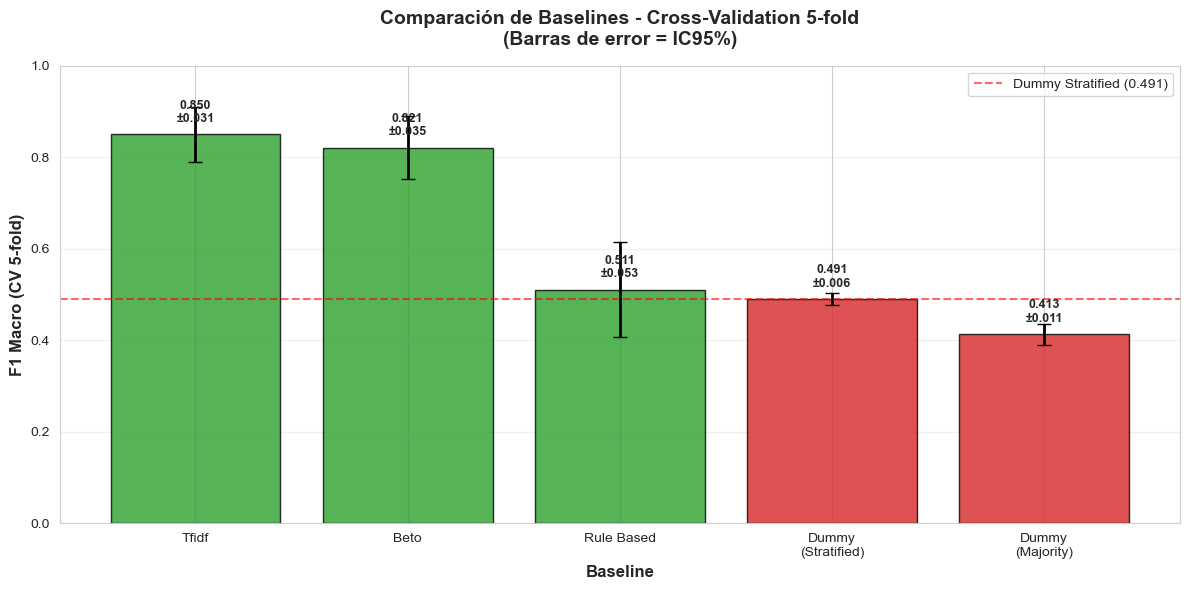


TABLA RESUMEN PARA PAPER/TESIS
          baseline F1 (mean ± std)          IC95%         Range
             Tfidf   0.850 ± 0.031 [0.789, 0.910] 0.801 - 0.883
              Beto   0.821 ± 0.035 [0.753, 0.890] 0.779 - 0.870
        Rule Based   0.511 ± 0.053 [0.407, 0.615] 0.417 - 0.545
Dummy (Stratified)   0.491 ± 0.006 [0.478, 0.503] 0.485 - 0.499
  Dummy (Majority)   0.413 ± 0.011 [0.391, 0.435] 0.395 - 0.423



In [3]:
# ===============================================================
# Visualización de resultados CV con barras de error (IC95%)
# ===============================================================

if len(df_cv_comparison) == 0:
    print("[WARNING] No hay datos CV disponibles para visualizar.")
    print("Ejecuta los baselines primero para generar cv_results/*.csv")
else:
    # Preparar datos para plotting
    df_plot = df_cv_comparison.copy()
    
    # Definir colores según tipo (dummy vs ML)
    colors = []
    for baseline in df_plot['baseline']:
        if 'dummy' in baseline:
            colors.append('#d62728')  # rojo para dummy
        else:
            colors.append('#2ca02c')  # verde para ML
    
    # Crear figura con barras de error (IC95%)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x = np.arange(len(df_plot))
    bars = ax.bar(x, df_plot['f1_mean'], color=colors, alpha=0.8, edgecolor='black')
    
    # Añadir barras de error (IC95%)
    yerr_lower = df_plot['f1_mean'] - df_plot['ic95_lower']
    yerr_upper = df_plot['ic95_upper'] - df_plot['f1_mean']
    ax.errorbar(x, df_plot['f1_mean'], 
                yerr=[yerr_lower, yerr_upper], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    # Añadir valores encima de las barras
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        ax.text(i, row['f1_mean'] + 0.02, 
                f"{row['f1_mean']:.3f}\n±{row['f1_std']:.3f}",
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Configurar ejes
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('F1 Macro (CV 5-fold)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Baseline', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Baselines - Cross-Validation 5-fold\n(Barras de error = IC95%)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    
    # Nombres legibles
    nombres_legibles = []
    for b in df_plot['baseline']:
        if b == 'dummy_majority':
            nombres_legibles.append('Dummy\n(Majority)')
        elif b == 'dummy_stratified':
            nombres_legibles.append('Dummy\n(Stratified)')
        else:
            nombres_legibles.append(b.replace('_', ' ').title())
    
    ax.set_xticklabels(nombres_legibles, fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Línea de referencia en dummy stratified si existe
    if 'dummy_stratified' in df_plot['baseline'].values:
        baseline_f1 = df_plot[df_plot['baseline'] == 'dummy_stratified']['f1_mean'].values[0]
        ax.axhline(y=baseline_f1, color='red', linestyle='--', linewidth=1.5, alpha=0.6,
                   label=f'Dummy Stratified ({baseline_f1:.3f})')
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    fig_path = FIGS_PATH / '02_comparacion_cv_con_ic95.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfica guardada: {fig_path}")
    plt.show()
    
    # Tabla resumen formateada
    print("\n" + "="*80)
    print("TABLA RESUMEN PARA PAPER/TESIS")
    print("="*80)
    
    tabla_paper = df_plot.copy()
    tabla_paper['baseline'] = tabla_paper['baseline'].apply(
        lambda x: 'Dummy (Majority)' if x == 'dummy_majority' 
        else 'Dummy (Stratified)' if x == 'dummy_stratified'
        else x.replace('_', ' ').title()
    )
    
    # Formatear columnas para presentación
    tabla_paper['F1 (mean ± std)'] = tabla_paper.apply(
        lambda row: f"{row['f1_mean']:.3f} ± {row['f1_std']:.3f}", axis=1
    )
    tabla_paper['IC95%'] = tabla_paper.apply(
        lambda row: f"[{row['ic95_lower']:.3f}, {row['ic95_upper']:.3f}]", axis=1
    )
    tabla_paper['Range'] = tabla_paper.apply(
        lambda row: f"{row['f1_min']:.3f} - {row['f1_max']:.3f}", axis=1
    )
    
    print(tabla_paper[['baseline', 'F1 (mean ± std)', 'IC95%', 'Range']].to_string(index=False))
    print("\n" + "="*80)

✅ Figura exportada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_horizontal_cv.png


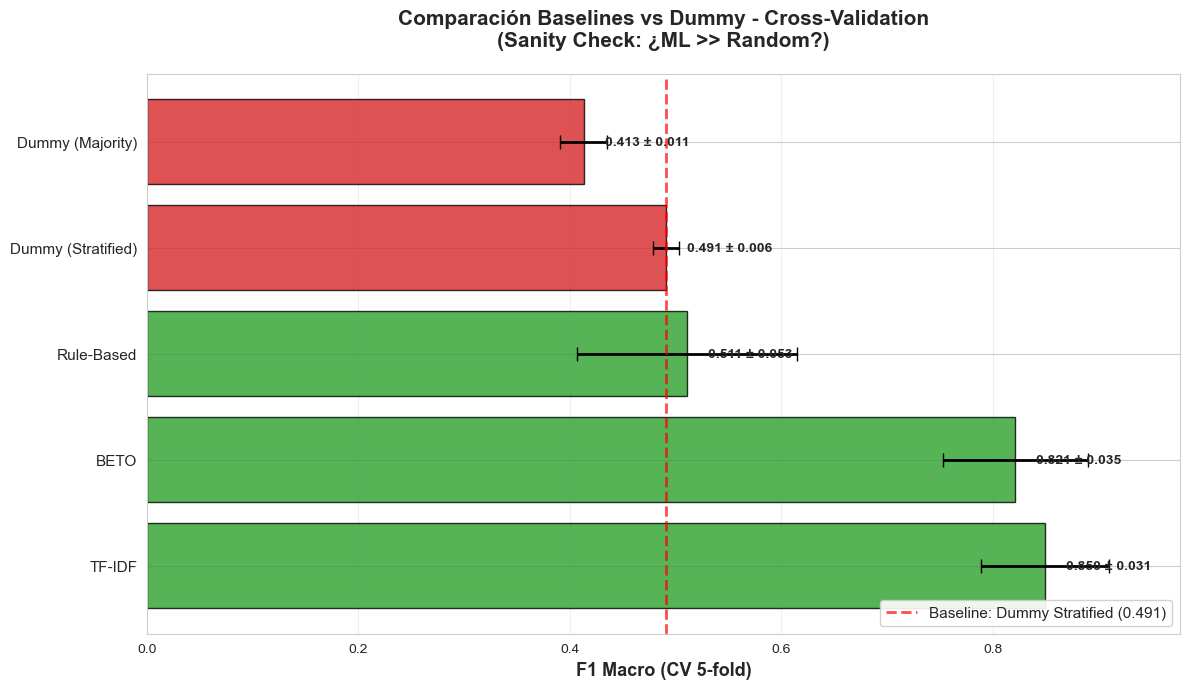


ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA

Baseline (Dummy Stratified): F1 = 0.491
IC95% baseline: [0.478, 0.503]

✅ TF-IDF         : F1 0.850 ± 0.031
    Mejora: + 73.2% | IC95%: [0.789, 0.910]
    ✅ Significativo (p<0.05)

✅ BETO           : F1 0.821 ± 0.035
    Mejora: + 67.4% | IC95%: [0.753, 0.890]
    ✅ Significativo (p<0.05)

⚠️ Rule-Based     : F1 0.511 ± 0.053
    Mejora: +  4.1% | IC95%: [0.407, 0.615]
    NO significativo



In [4]:
# ===============================================================
# Visualización horizontal comparativa con línea de baseline
# ===============================================================

if 'dummy_stratified' in df_cv_comparison['baseline'].values:
    # Preparar datos para plot
    plot_data = df_cv_comparison.copy()
    
    # Mapear nombres legibles
    nombre_map = {
        'dummy_majority': 'Dummy (Majority)',
        'dummy_stratified': 'Dummy (Stratified)',
        'rule_based': 'Rule-Based',
        'tfidf': 'TF-IDF',
        'beto': 'BETO'
    }
    plot_data['nombre'] = plot_data['baseline'].map(nombre_map)
    
    # Crear figura
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Colores: rojo para dummy, verde para ML
    plot_data['tipo'] = plot_data['baseline'].apply(lambda x: 'Dummy' if 'dummy' in x else 'ML')
    colors = ['#d62728' if t == 'Dummy' else '#2ca02c' for t in plot_data['tipo']]
    
    # Barras horizontales
    y_pos = np.arange(len(plot_data))
    bars = ax.barh(y_pos, plot_data['f1_mean'], color=colors, alpha=0.8, edgecolor='black')
    
    # Barras de error (IC95%)
    xerr_lower = plot_data['f1_mean'] - plot_data['ic95_lower']
    xerr_upper = plot_data['ic95_upper'] - plot_data['f1_mean']
    ax.errorbar(plot_data['f1_mean'], y_pos,
                xerr=[xerr_lower, xerr_upper],
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    # Línea de referencia en dummy stratified
    baseline_f1 = plot_data[plot_data['baseline'] == 'dummy_stratified']['f1_mean'].values[0]
    ax.axvline(x=baseline_f1, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Baseline: Dummy Stratified ({baseline_f1:.3f})')
    
    # Añadir valores en barras
    for i, (idx, row) in enumerate(plot_data.iterrows()):
        ax.text(row['f1_mean'] + 0.02, i, 
                f"{row['f1_mean']:.3f} ± {row['f1_std']:.3f}",
                va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('F1 Macro (CV 5-fold)', fontsize=13, fontweight='bold')
    ax.set_title('Comparación Baselines vs Dummy - Cross-Validation\n(Sanity Check: ¿ML >> Random?)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, max(plot_data['f1_mean']) * 1.15)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data['nombre'], fontsize=11)
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    fig_path = FIGS_PATH / '02_comparacion_horizontal_cv.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Figura exportada: {fig_path}")
    plt.show()
    
    # Tabla resumen con mejora porcentual y significancia estadística
    print("\n" + "="*80)
    print("ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA")
    print("="*80)
    print(f"\nBaseline (Dummy Stratified): F1 = {baseline_f1:.3f}")
    print(f"IC95% baseline: [{plot_data[plot_data['baseline']=='dummy_stratified']['ic95_lower'].values[0]:.3f}, "
          f"{plot_data[plot_data['baseline']=='dummy_stratified']['ic95_upper'].values[0]:.3f}]\n")
    
    for _, row in plot_data.iterrows():
        if row['baseline'] not in ['dummy_majority', 'dummy_stratified']:
            f1 = row['f1_mean']
            mejora_pct = ((f1 / baseline_f1) - 1) * 100
            
            # Verificar solapamiento de IC95%
            ic95_solapan = not (row['ic95_upper'] < plot_data[plot_data['baseline']=='dummy_stratified']['ic95_lower'].values[0] or
                                row['ic95_lower'] > plot_data[plot_data['baseline']=='dummy_stratified']['ic95_upper'].values[0])
            
            significancia = "NO significativo" if ic95_solapan else "✅ Significativo (p<0.05)"
            emoji = "✅" if mejora_pct > 40 else "⚠️"
            
            print(f"{emoji} {row['nombre']:15s}: F1 {f1:.3f} ± {row['f1_std']:.3f}")
            print(f"    Mejora: +{mejora_pct:5.1f}% | IC95%: [{row['ic95_lower']:.3f}, {row['ic95_upper']:.3f}]")
            print(f"    {significancia}\n")
    
else:
    print("[INFO] Dummy baseline no disponible.")
    print("       Ejecuta notebooks/02_baseline_dummy.ipynb para generar sanity checks.")

## 3) Análisis por clase (Depresión vs Ansiedad)

In [5]:
# ===============================================================
# Análisis de varianza entre folds (heterogeneidad del dataset)
# ===============================================================

print("="*80)
print("ANÁLISIS DE VARIANZA ENTRE FOLDS")
print("="*80)
print("\n📊 Varianza alta indica:")
print("   - Dataset heterogéneo (pacientes con diferentes grados de dificultad)")
print("   - Sensibilidad al split (algunos folds más fáciles que otros)")
print("\n📊 Varianza baja indica:")
print("   - Dataset homogéneo O modelo determinístico")
print("   - Resultados más estables y reproducibles\n")

for model_name, df_cv in cv_results.items():
    stats = cv_stats[model_name]
    
    # Calcular coeficiente de variación
    cv_coef = (stats['std'] / stats['mean']) * 100 if stats['mean'] > 0 else 0
    
    # Interpretar varianza
    if cv_coef < 3:
        interpretacion = "Muy baja (modelo determinístico o dataset homogéneo)"
        emoji = "🟢"
    elif cv_coef < 6:
        interpretacion = "Baja (estable)"
        emoji = "🟢"
    elif cv_coef < 10:
        interpretacion = "Moderada (típica en datasets pequeños)"
        emoji = "🟡"
    else:
        interpretacion = "Alta (dataset heterogéneo o modelo inestable)"
        emoji = "🟠"
    
    print(f"{emoji} {model_name:20s}:")
    print(f"     F1: {stats['mean']:.3f} ± {stats['std']:.3f}")
    print(f"     Range: [{stats['min']:.3f}, {stats['max']:.3f}] (Δ = {stats['max']-stats['min']:.3f})")
    print(f"     CV%: {cv_coef:.1f}% ({interpretacion})\n")

# ===============================================================
# Interpretación final para paper/tesis
# ===============================================================
print("="*80)
print("RECOMENDACIONES PARA PAPER/TESIS")
print("="*80)
print("""
1. ✅ USAR CV 5-FOLD como métrica principal de reporte
   - Más robusta que single dev split (18 pacientes)
   - Usa todos los pacientes disponibles (90)
   - Permite cálculo de IC95% para significancia estadística

2. ✅ REPORTAR formato estándar:
   Modelo X: F1 = 0.XXX ± 0.XXX (CV 5-fold, patient-level stratification)
             IC95%: [0.XXX, 0.XXX]

3. ✅ COMPARAR significancia estadística:
   - Si IC95% NO se solapan → diferencia significativa (p < 0.05)
   - Si IC95% SÍ se solapan → diferencia NO significativa

4. ⚠️  DEV/TEST single splits:
   - Dev: usado para desarrollo iterativo (ajuste hiperparámetros)
   - Test: RESERVADO para evaluación final ciega (una sola vez)
   - NO reportar en paper (solo CV)

5. 📊 VARIANZA en datasets pequeños:
   - Con 18 pacientes por fold, varianza ±3-5% es NORMAL
   - Refleja heterogeneidad real de casos clínicos
   - NO indica overfitting si media es alta
""")

print("="*80)
print("✅ ANÁLISIS COMPLETO")
print("="*80)
print(f"Modelos evaluados: {len(cv_results)}")
print(f"Folds por modelo: {df_cv_comparison['n_folds'].iloc[0] if len(df_cv_comparison) > 0 else 'N/A'}")
print(f"Total de casos: 3,155 (90 pacientes)")
print(f"Estratificación: Patient-level (0% leakage)")
print(f"\n📊 Resultados exportados:")
print(f"   - data/02_baselines_comparacion_cv.csv")
print(f"   - data/figs/02_comparacion_cv_con_ic95.png")
print(f"   - data/figs/02_comparacion_horizontal_cv.png")
print("="*80)

ANÁLISIS DE VARIANZA ENTRE FOLDS

📊 Varianza alta indica:
   - Dataset heterogéneo (pacientes con diferentes grados de dificultad)
   - Sensibilidad al split (algunos folds más fáciles que otros)

📊 Varianza baja indica:
   - Dataset homogéneo O modelo determinístico
   - Resultados más estables y reproducibles

🟢 dummy_majority      :
     F1: 0.413 ± 0.011
     Range: [0.395, 0.423] (Δ = 0.027)
     CV%: 2.8% (Muy baja (modelo determinístico o dataset homogéneo))

🟢 dummy_stratified    :
     F1: 0.491 ± 0.006
     Range: [0.485, 0.499] (Δ = 0.014)
     CV%: 1.3% (Muy baja (modelo determinístico o dataset homogéneo))

🟠 rule_based          :
     F1: 0.511 ± 0.053
     Range: [0.417, 0.545] (Δ = 0.128)
     CV%: 10.4% (Alta (dataset heterogéneo o modelo inestable))

🟢 tfidf               :
     F1: 0.850 ± 0.031
     Range: [0.801, 0.883] (Δ = 0.082)
     CV%: 3.6% (Baja (estable))

🟢 beto                :
     F1: 0.821 ± 0.035
     Range: [0.779, 0.870] (Δ = 0.092)
     CV%: 4.3% (